In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNWithMeans,CoClustering, \
                     KNNWithZScore,KNNBaseline,BaselineOnly, NormalPredictor
from wordcloud import STOPWORDS
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# RECOMMENDATION SYSTEM

Build recommendation engine with hybrid approach (content-based + collaborative filtering recommendation) with the dataset TMDB 5000 Movie Dataset, the user rating from Kaggle Dataset.

In [81]:
user_rating = pd.read_csv(r'F:\01_Dataset\04 Tabular\02 Movie Recommendation System\01 Dataset\ratings_small.csv')
credit = pd.read_csv(r'F:\01_Dataset\04 Tabular\02 Movie Recommendation System\01 Dataset\tmdb_5000_credits.csv')
movie = pd.read_csv(r'F:\01_Dataset\04 Tabular\02 Movie Recommendation System\01 Dataset\tmdb_5000_movies.csv')

In [82]:
user_rating.head()

,userId,rating,title
0,2,3.0,Ocean's Eleven
1,2,3.0,Batman Begins
2,2,4.0,Terminator 3: Rise of the Machines
3,2,4.0,Catwoman
4,2,3.0,Batman Returns


In [83]:
print("Number of unique user is :",user_rating['userId'].nunique())
print("Number of unique movie is :",user_rating['title'].nunique())

Number of unique user is : 653
Number of unique movie is : 289


## PART I : CONTENT-BASED RECOMMENDATION

### STEP 1: DATA PROCESSING & FEATURE EXTRACTION

This step is to extract the data from list-form dataframe for content-based recommendation into four individual attribute in the following detail,

- **Lead** : The three main cast who plays the role of the protagonist or leading role of a film.
- **Director** : The person who has a *key role* in choosing the cast members, production design and all the creative aspects of filmmaking.
- **Genres** : The Stylistic or thematic category for motion pictures based on similarities either in the narrative elements, aesthetic approach, or the emotional response to the film such as Action,Adventure,Fantasy,Science,Fiction etc.
- **Keyword** : a word or a sort of phrase that can be associated with plot of films.

In [84]:
def lead(x):
    for i in x:
        names = [i['name'] for i in x]
        names = names[:3]
        return names
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
def extract(x):
    for i in x:
        gen = [i['name'] for i in x]
        return gen
def metric_score(x):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    tfidf = TfidfVectorizer()
    tfidf_mat = tfidf.fit_transform(x)
    x_df = pd.DataFrame(tfidf_mat.toarray(),columns=tfidf.get_feature_names(),index=final_mov.index)
    x_final = pd.DataFrame(cosine_similarity(x_df),columns=final_mov['title_2'],index=final_mov.index)
    x_final = pd.DataFrame(x_final.unstack(level=1))
    x_final.columns = list
    x_final.reset_index(inplace=True)
    x_final['help'] = x_final['title_2'] + x_final['title']
    return x_final 

In [85]:
list = ['cast','crew']
for i in list:
    credit[i] = credit[i].apply(literal_eval)
list2 = ['genres','keywords']
for i in list2:
    movie[i] = movie[i].apply(literal_eval)

In [86]:
credit['lead'] = credit['cast'].apply(lead)
credit['director'] = credit['crew'].apply(director)
credit.isnull().sum()

movie_id     0
title        0
cast         0
crew         0
lead        43
director    30
dtype: int64

In [87]:
credit.dropna(inplace=True)

In [88]:
#lead role extraction
lead = credit['lead'].apply(pd.Series)
lead.fillna(' ',inplace=True)
lead['all'] = lead[0] + ' ' + lead[1] + ' ' + lead[2]
lead.head()

credit['lead'] = lead['all']
credit.head()

,movie_id,title,cast,crew,lead,director
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",Sam Worthington Zoe Saldana Sigourney Weaver,James Cameron
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",Johnny Depp Orlando Bloom Keira Knightley,Gore Verbinski
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",Daniel Craig Christoph Waltz Léa Seydoux,Sam Mendes
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",Christian Bale Michael Caine Gary Oldman,Christopher Nolan
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",Taylor Kitsch Lynn Collins Samantha Morton,Andrew Stanton


In [89]:
movie['genres_n'] = movie['genres'].apply(extract)
movie['kw_n'] = movie['keywords'].apply(extract)

#genre extraction
gen = movie['genres_n'].apply(pd.Series)
gen.fillna('',inplace=True)
gen['all'] = ''
for i in range(7):
    gen['all'] = gen['all'] + gen[i] + ' '
gen.head()

#keyword extraction
kw = movie['kw_n'].apply(pd.Series)
kw.fillna('',inplace=True)
kw['all'] = ''
for i in range(96):
    kw['all'] = kw['all'] + kw[i] + ' '
    
movie['genres_n'] = gen['all']
movie['kw_n'] = kw['all']
movie.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genres_n,kw_n
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,based on novel mars medallion space travel pri...


#### TEXT CLEANSING
To remove a insignificant word (STOPWORDS) to increase efficiency in recommendation algorithm.

In [90]:
#Remove STOP WORDS
def remove_stop_word(data):
    c = data.split(' ')
    all_word = []
    for i in c:
        if i not in STOPWORDS:
            all_word.append(i)
    data = ' '.join(u for u in all_word)
    return data
movie['kw_n'] = movie['kw_n'].apply(remove_stop_word)
movie.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genres_n,kw_n
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,spy based novel secret agent sequel mi6 britis...
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,based novel mars medallion space travel prince...


In [91]:
merge = credit.merge(movie,left_on='movie_id',right_on='id')
final_mov = merge[['title_x','lead','director','genres_n','kw_n']]
final_mov = final_mov.rename(columns={'title_x':'title','genres_n':'genres','kw_n':'keyword'})
final_mov.set_index('title',inplace=True)
final_mov['title_2'] = final_mov.index
final_mov.head()

,lead,director,genres,keyword,title_2
title,,,,,
Avatar,Sam Worthington Zoe Saldana Sigourney Weaver,James Cameron,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar
Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Keira Knightley,Gore Verbinski,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates of the Caribbean: At World's End
Spectre,Daniel Craig Christoph Waltz Léa Seydoux,Sam Mendes,Action Adventure Crime,spy based novel secret agent sequel mi6 britis...,Spectre
The Dark Knight Rises,Christian Bale Michael Caine Gary Oldman,Christopher Nolan,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,The Dark Knight Rises
John Carter,Taylor Kitsch Lynn Collins Samantha Morton,Andrew Stanton,Action Adventure Science Fiction,based novel mars medallion space travel prince...,John Carter


### STEP 2 : EXPLORATORY DATA ANALYSIS
Explore the data from TOP 5000 movie to find the relashionship between Movie director, Actor/Actress, Movie genres and the movie plot keyword.

In [93]:
def extract2(column,numb):
    a = []
    for i in final_mov[column]:
        for j in i.split(' '):
            a.append(j)
    b = pd.DataFrame(a)
    b = b[b[0] != '']
    c = b.value_counts()
    return c[:numb]

def extract3(column1,column2,numb):
    a = []
    b = []
    for i in range(len(final_mov[column1])):
        for j in final_mov[column1].iloc[i].split(' '):
            a.append(j)
            b.append(final_mov[column2].iloc[i])
    c = pd.DataFrame(zip(a,b),columns=[column1,column2])
    c['new'] = c[column1].astype('str') + ' ' + c[column2].astype('str')
    c = c[c[column1] != '']
    d = c['new'].value_counts()[:numb]
    return d

def extract_lead4(column1,numb):
    b = []
    e = []
    for i in range(len(final_mov['lead'])):
        c = [' '.join(i for i in final_mov['lead'][i].split(' ')[:2]),
         ' '.join(i for i in final_mov['lead'][i].split(' ')[2:4]),
         ' '.join(i for i in final_mov['lead'][i].split(' ')[4:6])]
        b = b + c
    for k in final_mov[column1]:
        for j in range(3):
            e.append(k)
    b_df = pd.DataFrame(b,columns=['lead'])
    e_df = pd.DataFrame(e,columns=[column1])
    all_c = pd.concat([b_df,e_df],axis=1)
    all_c = all_c[all_c['lead'] != all_c[column1]]
    all_c['new'] = all_c['lead'].astype('str') + ' ' + all_c[column1].astype('str')
    h = all_c['new'].value_counts()[:numb]
    return h

def extrac5(numb):
    b = []
    for i in range(len(final_mov['lead'])):
        c = [' '.join(i for i in final_mov['lead'][i].split(' ')[:2]),
         ' '.join(i for i in final_mov['lead'][i].split(' ')[2:4]),
         ' '.join(i for i in final_mov['lead'][i].split(' ')[4:6])]
        b = b + c
    b_df = pd.DataFrame(b,columns=['lead'])
    h = b_df['lead'].value_counts()[:numb]
    return h

def pair_plot(column1,column2,c1,c2,name1,name2):
    fig, axes = plt.subplots(1,2,figsize=(12,5))
    column1.plot(kind='bar',ax=axes[0],color=c1)
    column2.plot(kind='bar',ax=axes[1],color=c2)
    axes[0].tick_params(axis='x', labelrotation=60)
    axes[1].tick_params(axis='x',labelrotation=60)
    axes[0].set_ylabel('Numbers of Movies (No.)')
    axes[1].set_ylabel('Numbers of Movies (No.)')
    axes[0].set_title('Numbers of Movies by '+ name1)
    axes[1].set_title('Numbers of Movies by '+ name2)

direcetor_plot = final_mov['director'].value_counts()[:10]
genres_plot = extract2('genres',10)
keyword_plot = extract2('keyword',10)
lead_plot = extrac5(10)
genres_director_plot = extract3('genres','director',10)
keyword_director_plot = extract3('keyword','director',10)
lead_director_plot = extract_lead4('director',10)
lead_genres_plot = extract_lead4('genres',10)

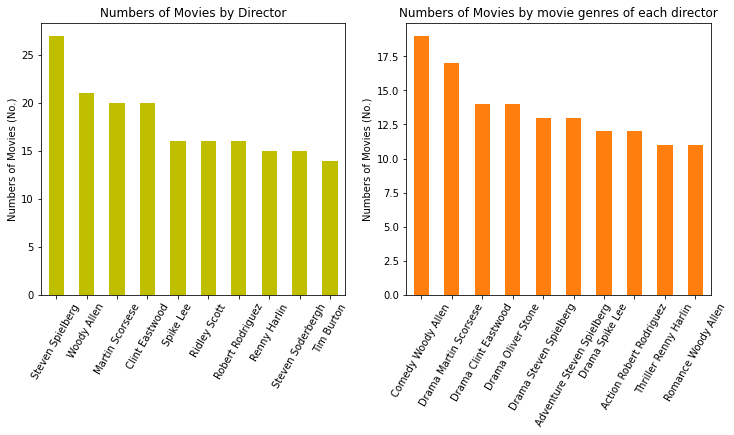

In [72]:
pair_plot(direcetor_plot,genres_director_plot,'y','tab:orange','Director','movie genres of each director')

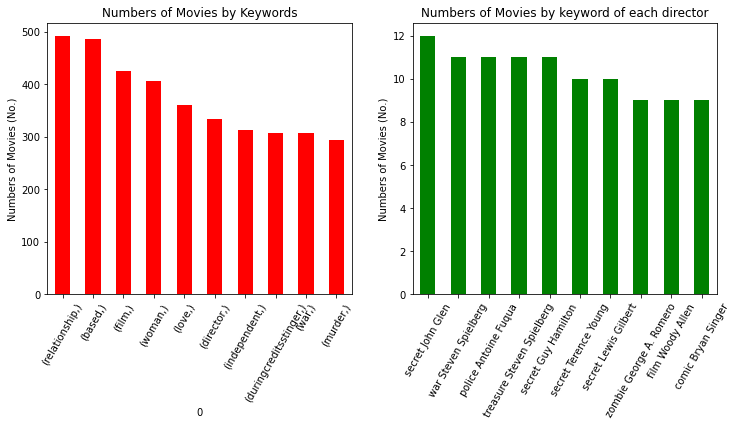

In [73]:
pair_plot(keyword_plot,keyword_director_plot,'r','g','Keywords','keyword of each director')

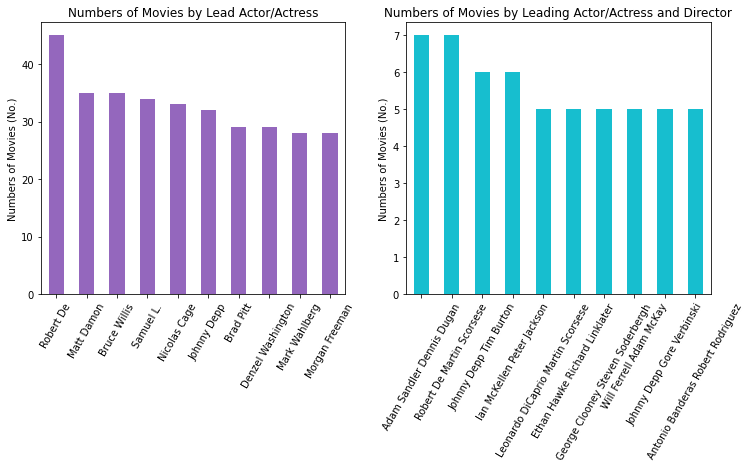

In [78]:
pair_plot(lead_plot,lead_director_plot,'tab:purple','tab:cyan','Lead Actor/Actress','Leading Actor/Actress and Director')

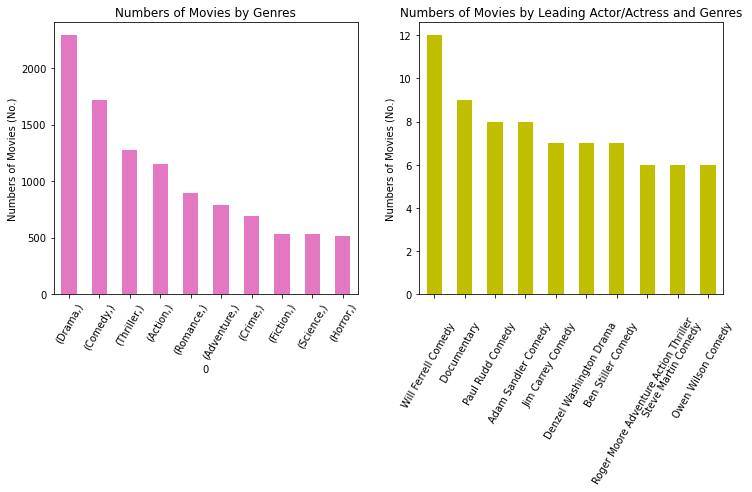

In [102]:
pair_plot(genres_plot,lead_genres_plot,'tab:pink','y','Genres','Leading Actor/Actress and Genres')

### STEP 3 : TFIDF CONVERSION

To recommend based on the content similarity, the data would be required to convert into matrix and provide the information of the data thourgh "term frequency–inverse document frequency(tf-idf)" approach and select the cosine similarity appilication to be a score for each film aspect.

In [48]:
def metric_score(x,list):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    tfidf = TfidfVectorizer()
    tfidf_mat = tfidf.fit_transform(x)
    x_df = pd.DataFrame(tfidf_mat.toarray(),columns=tfidf.get_feature_names_out(),index=final_mov.index)
    x_final = pd.DataFrame(cosine_similarity(x_df),columns=final_mov['title_2'],index=final_mov.index)
    x_final = pd.DataFrame(x_final.unstack(level=1))
    x_final.columns = list
    x_final.reset_index(inplace=True)
    x_final['help'] = x_final['title_2'] + x_final['title']
    return x_final 

In [49]:
keyword_score = metric_score(final_mov['keyword'],['keyword_score'])
lead_score = metric_score(final_mov['lead'],['lead_score'])
director_score = metric_score(final_mov['director'],['director_score'])
genres_score = metric_score(final_mov['genres'],['genres_score'])

## Part II : Collaborative-Filtered Recommendation BY SURPRISE library
### STEP 4 : ALGORITHM PRELIMINARY SELECTION
This step is to premilimary search for the top three collaborative-filtering algorithm with least accuracy measured by 'RMSE' in movie rating prediction based on cross validation approach between algorithm provided in "SURPRISE" library in the following type:
- **Matrix Factorization approach** : Singular Value Decompition (SVD), Singular Value Decompition (SVD++) ,nmf non negative matrix factorization (NMF).
- **KNN Species** : KNNBasic, KNNWithMeans,KNNWithZScore,KNNBaseline.
- **Others** : SlopeOne, NormalPredictor, BaselineONly


In [4]:
reader = Reader(rating_scale=(0,5.0))
data = Dataset.load_from_df(user_rating[['userId','title','rating']],reader)

In [5]:
#cross_validation
rmse_table = []
for algo in [SVD(), SVDpp(), NMF(), SlopeOne(), KNNBasic(), KNNWithMeans(),CoClustering()\
             ,KNNWithZScore(),KNNBaseline(),BaselineOnly(), NormalPredictor(),]:
    cross = cross_validate(algo,data,measures=['rmse'],cv=10)
    results = pd.DataFrame.from_dict(cross).mean(axis=0)
    results = results.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    rmse_table.append(results)
rmse_table = pd.DataFrame(rmse_table)
rmse_table = rmse_table.set_index('Algorithm')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [6]:
rmse_table = rmse_table.sort_values(by='test_rmse',ascending=True)
rmse_table

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.907993,2.040638,0.018778
BaselineOnly,0.916899,0.005226,0.002113
SVD,0.917604,0.295772,0.001961
KNNBaseline,0.921391,0.035792,0.062694
KNNBasic,0.959228,0.030302,0.048676
KNNWithZScore,0.965575,0.055162,0.064779
KNNWithMeans,0.970606,0.039903,0.051419
SlopeOne,0.972486,0.009375,0.009370
CoClustering,1.003136,0.162590,0.006248


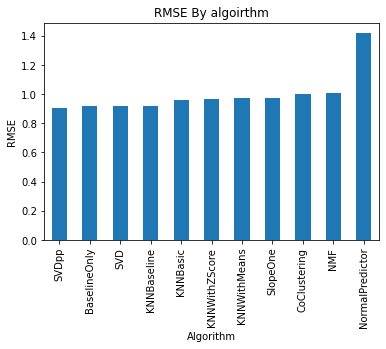

In [139]:
rmse_table['test_rmse'].plot(kind='bar')
plt.title('RMSE By algoirthm')
plt.ylabel('RMSE')
plt.show()

   The result showed that the top three algorithm in terms of least Root Mean Square Error (RMSE) are "SVD++,BaselineOnly, SVD". Therefore, those algorithm would be selected for fine-tuning and compare with the best parameter to finalize the best appropriate algorithm for this dataset.
   
### STEP 5 : ALGORITHM FINE TUNING

This step is to compare between the selected algorithm for finding the best algorithm with best paramater with "GridSearchCV" and measure it within the test set.

In [7]:
trainset, testset = train_test_split(data,test_size=0.2)

In [8]:
svd = SVD()
params = {'n_factors': [25, 30, 35, 40, 100], 
     'n_epochs': [15, 20, 25], 
     'lr_all': [0.001, 0.003, 0.005, 0.008],
     'reg_all': [0.08, 0.1, 0.15, 0.02]}
svd_gs = GridSearchCV(SVD,params,measures=['rmse'],cv=3)
svd_gs.fit(data)
print(svd_gs.best_score['rmse'])
print(svd_gs.best_params['rmse'])

0.9203017211057949
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.1}


In [21]:
svd = SVD(n_factors=25,n_epochs=25,lr_all=0.008,reg_all=0.1)
svd_pred = svd.fit(trainset).test(testset)
accuracy.rmse(svd_pred)

RMSE: 0.9181


0.9180777818673114

In [10]:
params = {'n_factors': [25, 30, 35, 40, 100], 
     'n_epochs': [15, 20, 25], 
     'lr_all': [0.001, 0.003, 0.005, 0.008],
     'reg_all': [0.08, 0.1, 0.15, 0.02]}
svdpp_gs = GridSearchCV(SVDpp,params,measures=['rmse'],cv=3)
svdpp_gs.fit(data)
print(svdpp_gs.best_score['rmse'])
print(svdpp_gs.best_params['rmse'])

0.9153819733349194
{'n_factors': 30, 'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.02}


In [22]:
svdpp = SVDpp(n_factors=30,n_epochs=15,lr_all=0.008,reg_all=0.02)
svdpp_pred = svdpp.fit(trainset).test(testset)
accuracy.rmse(svdpp_pred)

RMSE: 0.9129


0.9129348466063125

In [12]:
param_grid = {'bsl_options':{'method': ['als','sgd'],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}}
bs_gs = GridSearchCV(BaselineOnly,param_grid,measures=['rmse'],cv=3)
bs_gs.fit(data)
print(bs_gs.best_score['rmse'])
print(bs_gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [13]:
baseline = BaselineOnly(bsl_options= {'method': 'als', 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4})
baseline_pred = baseline.fit(trainset).test(testset)
accuracy.rmse(baseline_pred)

Estimating biases using als...
RMSE: 0.9194


0.9194086888738019

With these step, I found out that the best algorithm is "SVP++" with rmse is 0.9129 for test set. Therefore, I decided to select this algorithm for "Individual User Movie Rating Prediction".

### STEP 6 : RATING PREDICTION

this step is to prediction movie rating score with the total dataset to predict the movie rating as the user preference score in the hybrid recommmendation step.

In [131]:
svdpp = SVDpp(n_factors=30,n_epochs=15,lr_all=0.008,reg_all=0.02)
svdpp_pred = svdpp.fit(data.build_full_trainset())

In [27]:
title_list = user_rating['title'].unique()
user_list = user_rating['userId'].unique()
user_rat = []
user_id = 2
for i in user_list:
    for j in title_list:
        rating = svdpp_pred.predict(uid=i,iid=j)
        user_rat.append((i,j,rating.est))
rating_predict = pd.DataFrame(user_rat,columns=['userId','title','pred_rating'])

In [28]:
rating_predict.head()

,userId,title,pred_rating
0,2,Ocean's Eleven,3.553145
1,2,Batman Begins,3.709912
2,2,Terminator 3: Rise of the Machines,3.884953
3,2,Catwoman,3.688455
4,2,Batman Returns,3.437419


## PART III : HYBRID RECOMMENDATION

### STEP 7 : PERSONALISED RECOMMENDATION SCORE DEVELOPMENT

This step is to merge between the similarity score for being a representative score for each film with and indivudual movie rating prediction to construct the personalised score with following methodology:

**Similarity Score** = 0.4 * keyword + 0.3 * lead + 0.2 * director + 0.1 * genres

**Personalised Favourite Score** = Similarity Score * prediction Rating / 2.5

In [119]:
def recommend_top_movie(title,user,number):
    b = keyword_score[keyword_score['title_2'] == title]
    for i in [lead_score,director_score,genres_score]:
        c = b.merge(i[i['title_2'] == title],on='help')
        c = c.rename(columns={'title_2_x':'title_2','title_x':'title'})
        c = c.drop(['title_2_y','title_y'],axis=1)
        b = c
    c = c.rename(columns={'title_2':'title','title':'recommended_title'})
    recommend = c
    recommend['similarity_score'] = (recommend['keyword_score']*0.4) +\
                                    (recommend['lead_score']*0.3) +\
                                    (recommend['director_score']*0.2) +\
                                    (recommend['genres_score']*0.1) 
    
    for i in [user_rating,rating_predict]:
        i['help'] = i['userId'].astype('str') + i['title']
    new = rating_predict.merge(user_rating,how='left',on='help')
    new = new[['userId_x','title_x','rating','pred_rating']]
    new = new.rename(columns={'userId_x':'userId','title_x':'title'})
    new = new.fillna(0.0)
    new = new[(new['userId'] == user) & (new['rating'] == 0.0)]
    new['fav_score'] = new['pred_rating'] / 2.5

    final_recommend = recommend.merge(new,left_on='recommended_title',right_on='title',how='left')
    final_recommend['fav_score'] = final_recommend['fav_score'].fillna(1.0)
    final_recommend['final_score'] = final_recommend['similarity_score'] * final_recommend['fav_score']
    final_recommend = final_recommend[final_recommend['recommended_title'] != title]
    final_recommend = final_recommend.sort_values(by='final_score',ascending=False)
    final_recommend = final_recommend.head(number)
    return final_recommend['recommended_title'].values

### RECOMMENDATION NO.1
10 recommended movie for UserID : 5 who have previously watched "Harry Potter and the Goblet of Fire"

In [120]:
recommend_top_movie('Harry Potter and the Goblet of Fire',5,10)

array(["Harry Potter and the Philosopher's Stone",
       'Harry Potter and the Half-Blood Prince',
       'Harry Potter and the Prisoner of Azkaban',
       'Harry Potter and the Chamber of Secrets',
       'Harry Potter and the Order of the Phoenix',
       'Love in the Time of Cholera', 'Eragon',
       'Prince of Persia: The Sands of Time', 'The Golden Compass',
       'Mona Lisa Smile'], dtype=object)

### RECOMMENDATION NO.2
5 recommended movie for UserID : 3 who have previously watched "Titanic"

In [141]:
recommend_top_movie('Titanic',3,5)

array(['Terminator 2: Judgment Day', 'Revolutionary Road',
       'Almost Famous', 'True Lies', 'Vanilla Sky'], dtype=object)